In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #繪圖
import warnings
import scipy.stats as stats
from collections import Counter

#前處理
from sklearn.preprocessing import MinMaxScaler #正規化
from sklearn.model_selection import train_test_split #分為訓練與驗證/測試集
from imblearn.over_sampling import SMOTE #生成人工樣本

#模型
from sklearn.svm import SVC #支持向量機
from sklearn.ensemble import GradientBoostingClassifier

#驗證
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

# 讀取玉山銀行信用卡盜刷的訓練資料

* 使用pd.read_csv讀，讀完後的資料為pd.Dataframe的資料格式
* pd.Dataframe中使用.columns獲取每欄的名稱
* pd.Dataframe中使用.head(n)可以獲取前n欄資料呈現，預設n為5
* pd.Dataframe中使用.dtypes可以獲取每欄的型別

In [2]:
RawData = pd.read_csv(r"C:\Users\哲旻\Documents\GitHub\玉山銀行信用卡盜刷\研究 - 玉山銀行比賽\train\train.csv")
FeatureNames = RawData.columns
#Data = RawData.as_matrix()
#print("原始資料的訓練集數量：%s" %(len(Data)))

print("欄位名稱：")
print(FeatureNames)

### fraud_ind 

欄位名稱：
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey'],
      dtype='object')


In [3]:
RawData.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6881,113261,38038,513.80,5,0,N,0,N,N,...,0,33,172652.0,457,59333,N,0,102,0,516056
1,0,134508,45725,465.62,5,0,N,2,N,N,...,0,9,105114.0,451,0,N,5817,102,0,4376
2,6881,15408,188328,513.80,5,0,N,0,N,N,...,0,6,152458.0,457,59333,N,0,102,0,483434
3,6716,157159,29967,1016.11,5,62,N,5,N,N,...,0,5,172946.0,247,50436,N,3281,102,0,1407164
4,5975,105985,81305,713.66,5,62,N,4,N,N,...,0,6,182129.0,263,93775,N,5817,102,0,1051004


In [4]:
#檢查每個欄位的型別
RawData.dtypes

acqic          int64
bacno          int64
cano           int64
conam        float64
contp          int64
csmcu          int64
ecfg          object
etymd          int64
flbmk         object
flg_3dsmk     object
fraud_ind      int64
hcefg          int64
insfg         object
iterm          int64
locdt          int64
loctm        float64
mcc            int64
mchno          int64
ovrlt         object
scity          int64
stocn          int64
stscd          int64
txkey          int64
dtype: object

# 資料分析

* 第一步：先將所有資料類型作分類
* 第二步：針對不同的型別視覺化
    1. object用一般方式把計算所有值的數量打印出來
        * 處理NAN值(刪除整列 或是 補正常值)
        * 多類別若沒有排序關係，則使用one-hot；若有排序關係，則不作處理。
    2. float用繪圖方式(盒型圖或長條圖)視覺化出來
        * 處理NAN值(刪除整列 或是 補平均值)
        * 找出資料是否有離群值，考慮是否刪除
    3. int用繪圖方式(盒型圖或長條圖)視覺化出來
        * 處理NAN值(刪除整列 或是 補正常值/中位數)
        * 找出資料是否有離群值，考慮是否刪除

In [5]:
#先對資料型別作分類，將name存至列表

int_columns = []
float_columns = []
object_columns = []
for dtype, column in zip(RawData.dtypes, RawData.columns):
    if dtype == 'float64':
        float_columns.append(column)
    elif dtype == 'int64':
        int_columns.append(column)
    else:
        object_columns.append(column)
        
print("浮點數型別數量：%s" %(len(float_columns)))
print("整數型別數量：%s" %(len(int_columns)))
print("物件型別數量：%s" %(len(object_columns)))

浮點數型別數量：2
整數型別數量：16
物件型別數量：5


## object
* pd中的DataFrame.value_counts方法，可以查看該欄位的值(dropna為不顯示nan值，因此False可查看是否有缺失值)

In [6]:
for obj in object_columns:
    print("\n=========== %s ==========="%(obj))
    print(RawData[obj].value_counts(dropna = False))


=========== ecfg ===========
N    1134512
Y     387275
Name: ecfg, dtype: int64

=========== flbmk ===========
N      1504133
NaN      12581
Y         5073
Name: flbmk, dtype: int64

=========== flg_3dsmk ===========
N      1444867
Y        64339
NaN      12581
Name: flg_3dsmk, dtype: int64

=========== insfg ===========
N    1479475
Y      42312
Name: insfg, dtype: int64

=========== ovrlt ===========
N    1501536
Y      20251
Name: ovrlt, dtype: int64


In [7]:
# 括弧第一個(逗點前)：RawData['name']=='Y'會回傳，每列的bool是否為Y
# 括弧第一個(逗點後)：name為要改的欄位

for obj in object_columns:
    RawData.loc[RawData[obj]=='Y',obj]=0
    RawData.loc[RawData[obj]=='N',obj]=1

In [8]:
#再次檢查所有值，看看N, Y是否完全取代變為1, 0
for obj in object_columns:
    print("\n=========== %s ==========="%(obj))
    print(RawData[obj].value_counts(dropna = False))


=========== ecfg ===========
1    1134512
0     387275
Name: ecfg, dtype: int64

=========== flbmk ===========
 1.0    1504133
NaN       12581
 0.0       5073
Name: flbmk, dtype: int64

=========== flg_3dsmk ===========
 1.0    1444867
 0.0      64339
NaN       12581
Name: flg_3dsmk, dtype: int64

=========== insfg ===========
1    1479475
0      42312
Name: insfg, dtype: int64

=========== ovrlt ===========
1    1501536
0      20251
Name: ovrlt, dtype: int64


## int
* 使用matplotlib.pyplot中的hist繪出長條圖，其中：
    * rwidth為長條圖的間距
    * alpha為顏色透明度
    * color為顏色

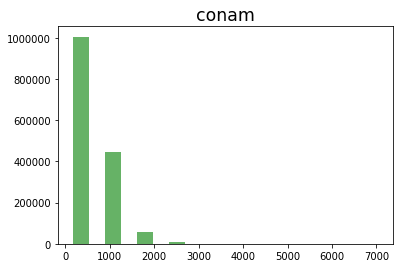

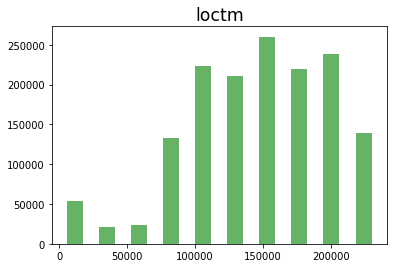

In [30]:
for flo in float_columns:
    plt.hist(RawData[flo], rwidth=0.5, alpha = 0.6, color = 'g')
    plt.title(flo,size ='xx-large')
    plt.show()

### 缺失值
* pd中的DataFrame.isnull()可以把有缺失值呈現出來，但資料太多不建議這麼做
* 若使用.any()可以知道哪欄有缺失值
* DataFrame[DataFrame.isnull().values==True]則可以只呈現有缺失值的那列
* df.fillna(0) 可以把0填補至缺失值 (這裡先不用)
* df.dropna() 可以返回一個無缺失值的dataframe

#### df.dropna()用法詳細可以至 [pandas刪除缺失值](https://riptutorial.com/zh-TW/pandas/example/6189/%E5%88%AA%E9%99%A4%E7%BC%BA%E5%A4%B1%E5%80%BC)    

In [28]:
RawData.isnull().any()

acqic        False
bacno        False
cano         False
conam        False
contp        False
csmcu        False
ecfg         False
etymd        False
flbmk         True
flg_3dsmk     True
fraud_ind    False
hcefg        False
insfg        False
iterm        False
locdt        False
loctm        False
mcc          False
mchno        False
ovrlt        False
scity        False
stocn        False
stscd        False
txkey        False
dtype: bool

In [36]:
RawData[RawData.isnull().values==True]

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
4827,6881,126303,109048,513.80,5,75,N,0,NaN,NaN,...,0,32,94554.0,457,86584,N,0,102,0,514184
4827,6881,126303,109048,513.80,5,75,N,0,NaN,NaN,...,0,32,94554.0,457,86584,N,0,102,0,514184
5906,0,85832,151082,465.62,5,75,N,2,NaN,NaN,...,0,75,101125.0,451,0,N,5817,102,0,35813
5906,0,85832,151082,465.62,5,75,N,2,NaN,NaN,...,0,75,101125.0,451,0,N,5817,102,0,35813
7136,6769,79167,66200,1.38,5,75,Y,8,NaN,NaN,...,0,62,95159.0,373,79246,N,5817,102,0,174845
7136,6769,79167,66200,1.38,5,75,Y,8,NaN,NaN,...,0,62,95159.0,373,79246,N,5817,102,0,174845
7523,0,108456,157230,465.62,5,75,N,2,NaN,NaN,...,0,58,101823.0,451,0,N,5817,102,0,27683
7523,0,108456,157230,465.62,5,75,N,2,NaN,NaN,...,0,58,101823.0,451,0,N,5817,102,0,27683
37299,0,137666,179303,465.62,5,75,N,2,NaN,NaN,...,0,8,104449.0,451,0,N,5817,102,0,3523
37299,0,137666,179303,465.62,5,75,N,2,NaN,NaN,...,0,8,104449.0,451,0,N,5817,102,0,3523


In [9]:
print("在RawData中，有缺失值的列數量：%s" %(len(RawData[RawData.isnull().values==True])))
print("在RawData中，無缺失值的列數量：%s" %(len(RawData.dropna())))

在RawData中，有缺失值的列數量：25162
在RawData中，無缺失值的列數量：1509206


In [10]:
Data_nonan = RawData.dropna()
print("在Data_nonan中，有缺失值的列數量：%s" %(len(Data_nonan[Data_nonan.isnull().values==True])))

在Data_nonan中，有缺失值的列數量：0


# 機器學習的前處理

### 提取輸入特徵與標籤

In [11]:
FeatureNames = Data_nonan.columns
print(FeatureNames)
Data = Data_nonan.as_matrix()

#提取輸入特徵與標籤
train_x = np.delete(Data, 10, axis=1) #np.array中刪除某欄
train_y = Data[:,10]

#計算類別的數量
print("類別數量：%s" %Counter(train_y))

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey'],
      dtype='object')
類別數量：Counter({0: 1489046, 1: 20160})


### 前處理：正規化至0與1間

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_x)
train_x = scaler.transform(train_x)

C:\Anaconda3\envs\ts101gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


### 交叉驗證：切分訓練集與驗證集

In [13]:
#交叉驗證所需要的驗證集
def CrossTestSet(Feature, Label, number):
    
    #變數初始化
    FeatureList, LabelList = [], []

    j = number
    for i in range(0,j-1 ,1):
        size = 1 / number
        
        #依序二元切割至k格
        Feature, CutFeature, Label, CutLabel = train_test_split(Feature, Label, random_state = 0, test_size = size) #0
       
        #切割後儲存至列表
        FeatureList.append(CutFeature)
        LabelList.append(CutLabel)

        number = number - 1
    
    #最後一次切割的樣本儲存至列表
    FeatureList.append(Feature)
    LabelList.append(Label)
    
    return FeatureList, LabelList

In [14]:
##交叉驗證所需要的訓練集
def CrossTrainSet(FeatureList, LabelList, CutNumber):

    #變數初始化
    Lenght = 0
    Train, Label = [], []
    TemporaryData, TemporaryLabel = [], []
    Data_x, Data_y = [], []

    #將已經切割好的測試集串接
    for i in range(0, CutNumber, 1):
        Data_x.extend(FeatureList[i])
        Data_y.extend(LabelList[i])
    
    #取每格的元素排列串接
    for i in range(0, CutNumber, 1):
    
        #第一次的儲存
        if(i==0):
            Train.append(Data_x[len(FeatureList[0]):])
            Label.append(Data_y[len(LabelList[0]):])
        
        #最後一次的儲存
        if(i==CutNumber-1):
            Train.append(Data_x[0:Lenght])
            Label.append(Data_y[0:Lenght])
            
        Lenght = Lenght+len(FeatureList[i])
        
        #中間的儲存(存前面與後面)
        if((i!=0)&(i!=CutNumber-1)):   
            FrontTemporaryData = TemporaryData
            FrontTemporaryData.extend(Data_x[Lenght:])
            Train.append(FrontTemporaryData)
        
            FrontTemporaryLabel = TemporaryLabel
            FrontTemporaryLabel.extend(Data_y[Lenght:])
            Label.append(FrontTemporaryLabel)
        
        #暫存目前跑過的列表內的元素
        TemporaryData = Data_x[:Lenght]
        TemporaryLabel = Data_y[:Lenght]
    
    #print("訓練集特徵的陣列個數：",len(Train))
    #print("訓練集標籤的陣列個數：",len(Label))
    
    return Train, Label

In [15]:
#產生交叉驗證的驗證集
cv_x, cv_y = CrossTestSet(train_x, train_y, 10) 

#產生交叉驗證的訓練集
train_x, train_y = CrossTrainSet(cv_x, cv_y, 10)

for i in range(len(cv_y)):
    print("第 %s 次：" %(i+1))
    print("訓練集之樣本%s" %Counter(train_y[i]))
    print("驗證集之樣本%s" %Counter(cv_y[i]))

第 1 次：
訓練集之樣本Counter({0: 1340172, 1: 18113})
驗證集之樣本Counter({0: 148874, 1: 2047})
第 2 次：
訓練集之樣本Counter({0: 1340164, 1: 18121})
驗證集之樣本Counter({0: 148882, 1: 2039})
第 3 次：
訓練集之樣本Counter({0: 1340179, 1: 18106})
驗證集之樣本Counter({0: 148867, 1: 2054})
第 4 次：
訓練集之樣本Counter({0: 1340111, 1: 18174})
驗證集之樣本Counter({0: 148935, 1: 1986})
第 5 次：
訓練集之樣本Counter({0: 1340232, 1: 18053})
驗證集之樣本Counter({0: 148814, 1: 2107})
第 6 次：
訓練集之樣本Counter({0: 1340141, 1: 18144})
驗證集之樣本Counter({0: 148905, 1: 2016})
第 7 次：
訓練集之樣本Counter({0: 1340061, 1: 18225})
驗證集之樣本Counter({0: 148985, 1: 1935})
第 8 次：
訓練集之樣本Counter({0: 1340116, 1: 18170})
驗證集之樣本Counter({0: 148930, 1: 1990})
第 9 次：
訓練集之樣本Counter({0: 1340183, 1: 18103})
驗證集之樣本Counter({0: 148863, 1: 2057})
第 10 次：
訓練集之樣本Counter({0: 1340055, 1: 18231})
驗證集之樣本Counter({0: 148991, 1: 1929})


In [ ]:
#變數初始化
save_average_cv = []
save_cv = []
save_Depth = []

for Depth in np.arange(2, 15, 1):     ###### GBDT 跑 for迴圈的參數 (這裡可以改)
    
    #變數初始化
    cv_pr_auc = 0
    temp_cv = []
    
    print("\n==== 超參數為%s時 ====" %(Depth))
    
    for i in range(len(cv_y)):
        
        #建立SMOTE生成(random_state：亂數固定，sampling_strategy：少數類別與多數類別的比率為1)
        SM = SMOTE(sampling_strategy = 1, random_state=0)
        
        #產生SMOTE生成後的資料
        smote_train_x, smote_train_y = SM.fit_sample(train_x[i], train_y[i])
        
        #建立模型(random_state：亂數固定，max_depth：最大深度，)
        GBDT = GradientBoostingClassifier(max_depth=Depth,random_state=0)
        
        #代入訓練集至模型訓練
        GBDT.fit(smote_train_x, smote_train_y)
        
        #代入驗證集至已經訓練好的模型作預測，並回傳機率值
        Predict_cv = GBDT.predict_proba(cv_x[i].astype('float64'))[:,1] 
        
        #計算在驗證集的PR曲線 (回傳查全率/查準率/每個樣本機率切點)
        precision, recall, thresholds = precision_recall_curve(cv_y[i].astype('float64'), Predict_cv) 
        
        #計算在驗證集PR曲線下的面積(代入查全率/查準率)
        pr_auc = auc(x=recall, y=precision) 
        
        #累加10次驗證集的PR曲線下的面積
        cv_pr_auc = cv_pr_auc + pr_auc
        
        #暫存第i+1次PR曲線下面積存到temp_cv列表中
        temp_cv.append(pr_auc)
        
        #打印第i+1次PR曲線下面積
        print("第 %s 次驗證集的PR AUC：%.4f" %(i+1, pr_auc))
    
    #儲存到列表(save_cv)：在超參數Depth深度下的10次交叉驗證PR曲線下的面積
    save_cv.append(temp_cv)
    
    #在超參數Depth深度下的10次交叉驗證PR曲線下的面積之平均值
    average_cv = cv_pr_auc/len(cv_y)
    
    #儲存到列表(save_average_cv)：average_cv
    save_average_cv.append(average_cv)
    
    #儲存此時的超參數Depth深度
    save_Depth.append(Depth)
    
    #打印average_cv
    print("平均交叉驗證：%.4f" %(average_cv))

#取最高的平均交叉驗證PR AUC值時的超參數Depth為此模型的最佳超參數 
#並回傳此時超參數的Index
max_index = save_average_cv.index(max(save_average_cv))

#打印最高的平均交叉驗證PR AUC值
print("\n最高之平均交叉驗證的PR AUC：%.4f" %(save_average_cv[max_index]))

#打印此時的超參數
print("此時的超參數為：%s" %(save_Depth[max_index]))